# Linear Models

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

### Easy

###### 4E1

In the model definition below, which line is the likelihood?
$$
\begin{align}
y_i &\sim \text{Normal($\mu, \sigma$)} \\
\mu &\sim \text{Normal(0, 10)} \\
\sigma &\sim \text{Uniform(0, 10)}
\end{align}
$$

**Answer:** The first line $y_i \sim \text{Normal($\mu, \sigma$)}$ represents the likelihood since it is the dependant upon $\mu$ and $\sigma$.

###### 4E2

In the model definition just above, how many parameters are there in the posterior distribution?

**Answer:** There are two parameters: $\mu$ and $\sigma$

###### 4E3

Using the model definition above, write down the approprite form of Bayes' theorem that includes proper likelihood and priors.  

**Answer:**   
$$
\text{Pr($\mu, \sigma$ | y)} = \frac{\prod_i \text{Normal($y_i | \mu, \sigma$) Normal($\mu | 0, 10$) Uniform($\sigma | 0, 10$)}}{\int\int\prod_i \text{Normal($y_i | \mu, \sigma$) Normal($\mu | 0, 10$) Uniform($\sigma | 0, 10$) } d\mu d\sigma}
$$

###### 4E4

In the model definition below, which line is the linear model?
$$
\begin{align}
y_i &\sim \text{Normal($\mu, \sigma$)} \\
\mu_i &= \alpha + \beta x_i \\
\alpha &\sim \text{Normal(0, 10)} \\
\beta &\sim \text{Normal(0, 1)} \\
\sigma &\sim \text{Uniform(0, 10)}
\end{align}
$$

**Answer:**: $\mu_i$ is the linear model as it is linearly dependant upon $x_i$

###### 4E5

In the model definition just above, how many parameters are there in the posterior distribution?

**Answer:** There are 3 parameters in posterior distribution: $\alpha$, $\beta$ and $\sigma$.

### Medium

###### 4M1

For the model definition below, simulate the observed heights from the prior (not the posterior).
$$
\begin{align}
y_i &\sim \text{Normal($\mu, \sigma$)} \\
\mu &\sim \text{Normal(0, 10)} \\
\sigma &\sim \text{Uniform(0, 10)}
\end{align}
$$

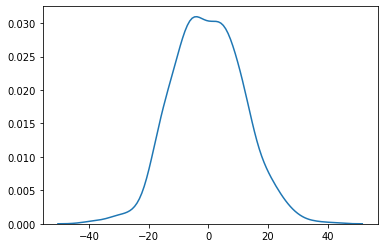

In [2]:
n_samples = 1000
mu = np.random.normal(0,10, n_samples)
sigma = np.random.uniform(0, 10, n_samples)
heights = np.random.normal(mu, sigma)
sns.kdeplot(heights);

###### 4M2

Translate the model just above into a `map` formula

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains, 1 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2328.48draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


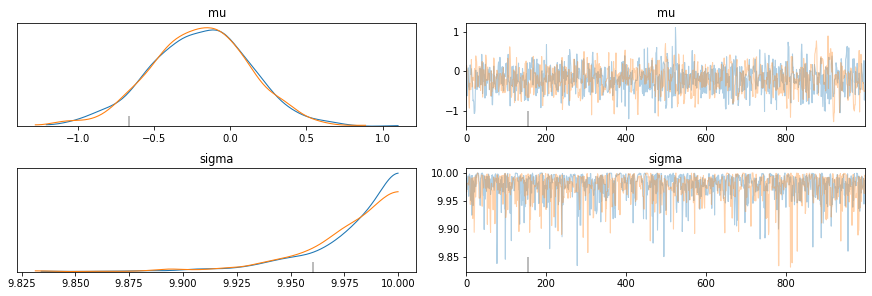

In [3]:
with pm.Model() as m_4m_2:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Normal('mu', mu=0, sd=10)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=heights)
    trace_4m_2 = pm.sample(1000, tune=1000)

pm.traceplot(trace_4m_2);

###### 4M3

Translate the `map` formula below into a mathematical model definition.

```
flist <- alist(
    y ~ dnorm( mu, sigma ),
    mu <- a + b*x,
    a ~ dnorm( 0, 50 ),
    b ~ dunif( 0, 10 ),
    sigma ~ dunif( 0, 50 )
)
```

**Answer:**  
$$
\begin{align}
y_i &\sim \text{Normal($\mu, \sigma$)} \\
\mu_i &= \alpha + \beta x_i \\
\alpha &\sim \text{Normal(0, 50)} \\
\beta &\sim \text{Uniform(0, 10)} \\
\sigma &\sim \text{Uniform(0, 10)}
\end{align}
$$

###### 4M4

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the methematical model definition for this regression, using any variable names and prior as you choose. Be prepared to defined you choice of priors.

**Answer:**  

Model:  
$$
\begin{align}
height_i &\sim \text{Normal($\mu, \sigma$)} \\
\mu_i &= \alpha + \beta time_i \\
\alpha &\sim \text{Normal(152, 25)} \\
\beta &\sim \text{Normal(6, 3)} \\
\sigma &\sim \text{Uniform(0, 50)}
\end{align}
$$

I assume that height is normally distributed, with $mu_i$ being a linear function of time. The $\alpha$ parameter represents the average height of a child (I assume 152cm per year with ±25cm deviation). The effect of time is driven by $\beta$. I assume that $\beta$ is normally distributed with mean 6cm grwoth per year with ±3 cm deviation. Finally, I assume a wide prior for the deivation of heights with a Uniform distribtion.

###### 4M5

Now suppose I tell you that the average height in the first year was 120 cm and that every student got taller every year. Does this information lead you to change your prior? How?

**Answer:** With the new information, I would change my priors as follows:
$$
\begin{align}
height_i &\sim \text{Normal($\mu, \sigma$)} \\
\mu_i &= \alpha + \beta time_i \\
\alpha &\sim \text{Normal(120, 25)} \\
\beta &\sim \text{LogNormal(6, 3)} \\
\sigma &\sim \text{Uniform(0, 50)}
\end{align}
$$

I reduce the average height for my $\alpha$ prior. Additionally, since I know that every student grew over the year, I can enfore the $beta$ coefficient to be strictly positive by changing it to be a LogNormal distribution.

###### 4M6

Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

**Answer:** A variance of 64cm implies that $\beta$ have a standard deviation of $\sqrt 64 = 8$. Therefore, we should assume that our $\beta$ distribution has a standard deviation of less than 8. Since I assume it to be 3cm, I do not change my prior.

### Hard

In [4]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d['weight_s'] = (d.weight - d.weight.mean()) / d.weight.std()

###### 4H1

The weights listed below were recorded in the !King census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals (either HPDI or PI) for each of these individuals. That is, fill in the table below, using model-based predictions.

| Individual | weight | expected height | 89% interval |
|------------|--------|-----------------|--------------|
| 1          | 46.95  |                 |              |
| 2          | 43.72  |                 |              |
| 3          | 64.78  |                 |              |
| 4          | 32.59  |                 |              |
| 5          | 54.63  |                 |              |

In [5]:
# Define the model
# Following assumptions from the book

weight_m = np.vstack((d.weight_s, d.weight_s**2, d.weight_s**3))
with pm.Model() as m_4h_1:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    heights = pm.Normal('heights', mu=mu, sd=sigma, observed=d.height)
    trace_4h_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 898.22draws/s] 


In [6]:
# Get samples from posterior for given weights
weights = np.array([48.95, 43.72, 64.78, 32.59, 54.63])
weights_s = (weights - d.weight.mean()) / d.weight.std()
n_samples = 1000
heights_pred = np.empty(shape=(n_samples, len(weights)))
for n in range(n_samples):
    i = np.random.randint(len(trace_4h_1))
    mu = trace_4h_1['alpha'][i] + np.multiply(trace_4h_1['beta'][i], np.array([weights_s, weights_s**2, weights_s**3]).T).sum(axis=1)
    sigma = trace_4h_1['sigma'][i]
    heights_pred[n,:] = np.random.normal(mu, sigma)
    

In [7]:
# mean heights
height_mean = heights_pred.mean(axis=0).round(2)

# 89% hpdi
hpdi = pm.stats.hpd(heights_pred, credible_interval=0.89).round(2)

In [8]:
# Answer
ans_4h_1 = pd.DataFrame([range(1,6), weights, height_mean, hpdi], index=['individual', 'weight', 'expected height', '89% interval']).T
ans_4h_1

,individual,weight,expected height,89% interval
0,1,48.95,157.61,"[150.15, 164.97]"
1,2,43.72,153.7,"[146.22, 160.98]"
2,3,64.78,178.8,"[170.25, 186.29]"
3,4,32.59,143.57,"[136.18, 151.2]"
4,5,54.63,162.9,"[154.41, 170.15]"


(130, 189.07)

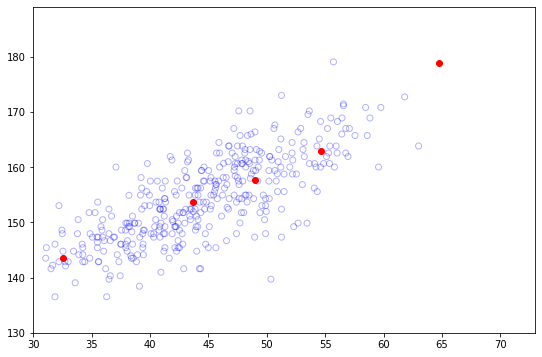

In [9]:
plt.figure(figsize=(9,6))
plt.scatter(d.weight, d.height, facecolors='none', edgecolors='b', alpha=0.3, )
plt.scatter(ans_4h_1.weight, ans_4h_1['expected height'], color='r')
plt.xlim([30,d.weight.max()+10])
plt.ylim([130, d.height.max()+10])

###### 4H2

Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.    

(a) Fit a linear regression to these data, using map. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?  

In [10]:
d2 = d[d.age < 18]

with pm.Model() as m_4h_2:
    sigma = pm.Uniform('sigma', lower=10, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sigma=10)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight)
    heights = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4h_2 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_4h_2, var_names=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1296.82draws/s]


,mean,sd,hpd_3%,hpd_97%
alpha,58.299,1.700,55.073,61.351
beta,2.717,0.083,2.562,2.875
sigma,10.170,0.159,10.001,10.458


**Answer:** Looking at the stats from the samples, a 10 unit increase in weight should lead to a $10 * 2.721 = 27.21$cm increase in height.

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Super- impose the MAP regression line and 89% HPDI for the mean. Also superimpose the 89% HPDI for predicted heights.    

100%|██████████| 2000/2000 [00:01<00:00, 1036.93it/s]


Text(0, 0.5, 'height')

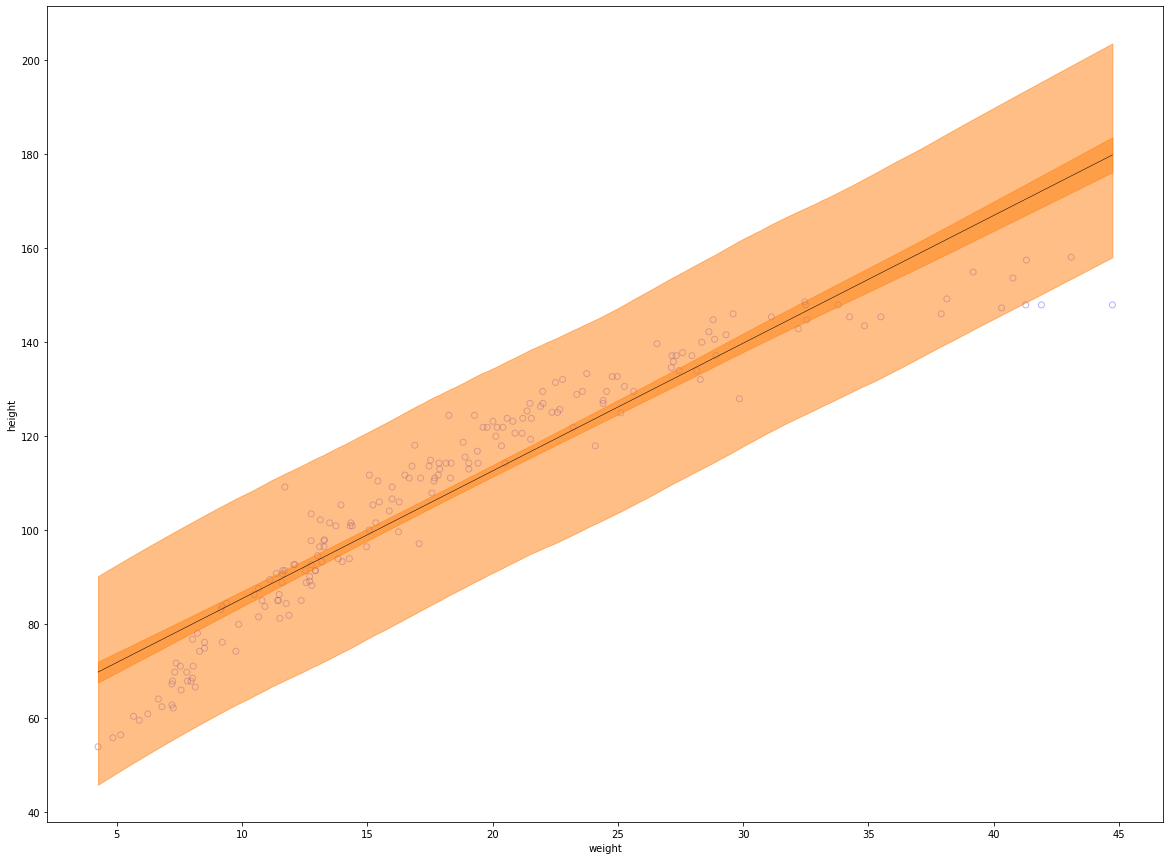

In [11]:
pred_height = pm.sample_posterior_predictive(trace_4h_2, model=m_4h_2)
plt.figure(figsize=(20,15))
# Plot raw data
plt.scatter(d2.weight, d2.height, facecolors='none', edgecolors='b', alpha=0.3)
# Plot 89% interval of mean height
pm.plot_hpd(d2.weight, trace_4h_2['mu'], credible_interval=0.89)
# Plot mean height prediction
sns.lineplot(d2.weight, trace_4h_2['mu'].mean(axis=0), color='black', linewidth=0.5)
# Plot height prediction
pm.plot_hpd(d2.weight, pred_height['height'], credible_interval=0.97)

# make labels
plt.xlabel('weight')
plt.ylabel('height')

(c) What aspects of the model fit concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don’t have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

**Answer:** The linear model seem to wrongly predict weights that are very low or very high. This may imply that the assumption that height is modelled by a linear relationship to weight may be wrong. A better hypothesis might be that the height changes as a non-linear relationship to weight, e.g. with weight and weight squared.

###### 4H3

Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens.  

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Fit this model, using quadratic approximation:  
$$
\begin{align}
h_i &\sim \text{Normal($\mu_i, \sigma$)} \\
\mu_i &= \alpha + \beta log(w_i) \\
\alpha &\sim \text{Normal(178, 100)} \\
\beta &\sim \text{Normal(0, 100)} \\
\sigma &\sim \text{Uniform(0, 50)}
\end{align}
$$

where $h_i$ is the height of individual i and $w_i$ is the weight (in kg) of individual i. The function for computing a natural log in R is just `log`. Can you interpret the resulting estimates?

In [12]:
with pm.Model() as m_4h_3:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sigma=100)
    mu = pm.Deterministic('mu', alpha + beta * np.log(d.weight))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4h_3 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_4h_3, var_names=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 705.18draws/s]


,mean,sd,hpd_3%,hpd_97%
alpha,-23.825,1.321,-26.124,-21.239
beta,47.087,0.378,46.366,47.772
sigma,5.156,0.158,4.879,5.455


**Answer:** The interpretation of alpha and beta are as follows:
1. beta: For every one unit increase in the log of weight (in kilos), height increases by about 47cm.
1. alpha: This alpha value is negative and not interpretable. Since `log(0)` is undefined, the value of alpha when weight is 0 is not possible to interpret.

(b) Begin with this plot:
```
 plot( height ~ weight , data=Howell1 ,
    col=col.alpha(rangi2,0.4) )
```

Then use samples from the quadratic approximate posterior of the model in (a) to superimpose on the plot:  
(1) the predicted mean height as a function of weight,  
(2) the 97% HPDI for the mean, and 
(3) the 97% HPDI for predicted heights.

100%|██████████| 2000/2000 [00:01<00:00, 1055.39it/s]


Text(0, 0.5, 'height')

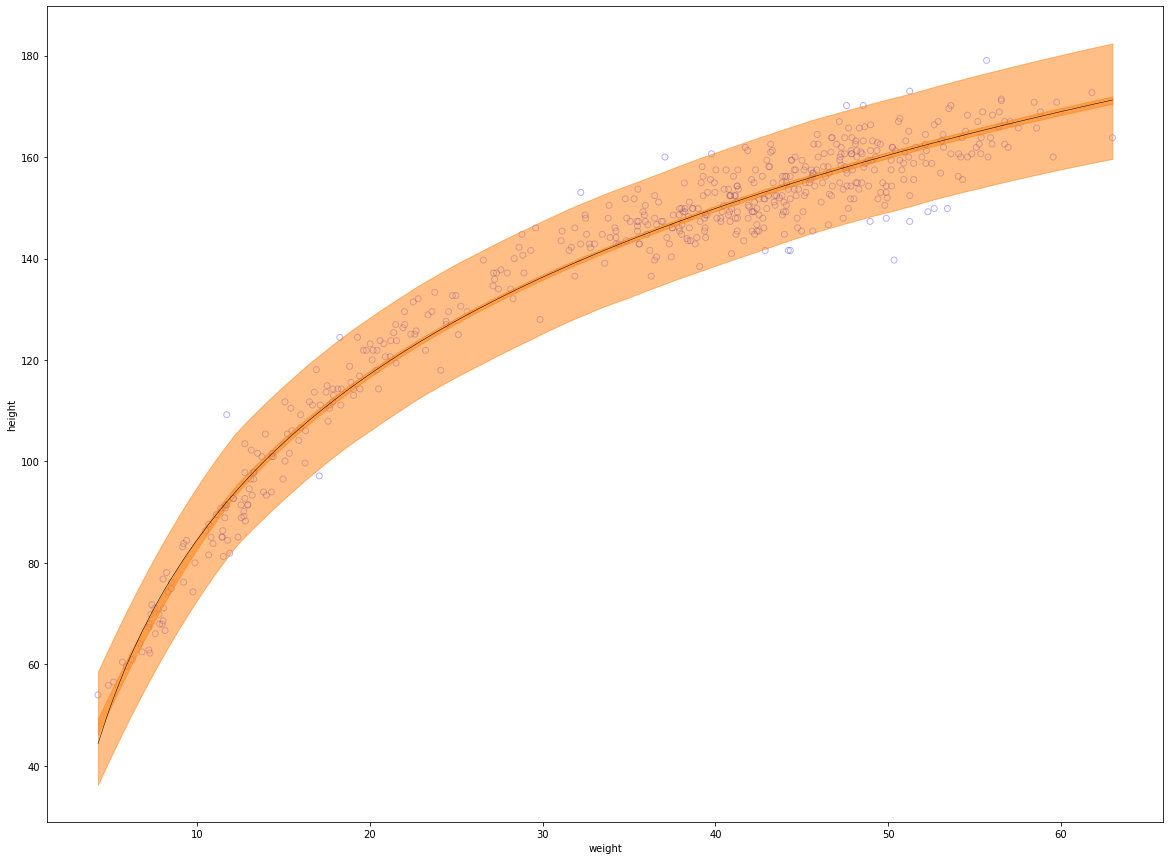

In [13]:
pred_height = pm.sample_posterior_predictive(trace_4h_3, model=m_4h_3)

# To manually calculate mean height
mu_pred = np.empty((np.shape(trace_4h_3['mu'])[0], np.shape(d.weight)[0]))
for i in range(len(d.weight)):
    mu_pred[:, i] = (trace_4h_3['alpha'] + trace_4h_3['beta'] * np.log(d.weight[i])).T

plt.figure(figsize=(20,15))
# Plot raw data
plt.scatter(d.weight, d.height, facecolors='none', edgecolors='b', alpha=0.3)
# Plot 89% interval of mean height
pm.plot_hpd(d.weight, trace_4h_3['mu'], credible_interval=0.97)
# Plot mean height prediction
sns.lineplot(d.weight, trace_4h_3['mu'].mean(axis=0), color='black', linewidth=0.5)
# Plot height prediction
pm.plot_hpd(d.weight, pred_height['height'], credible_interval=0.97)

# make labels
plt.xlabel('weight')
plt.ylabel('height')

In [14]:
import sys, IPython, scipy, matplotlib, platform, statsmodels, arviz
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\nArviz {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__, arviz.__version__))



This notebook was created using:
Python 3.7.6
IPython 7.12.0
PyMC3 3.8
Seaborn 0.10.0
NumPy 1.18.1
Pandas 1.0.1
Statsmodels 0.11.0
Matplotlib 3.1.3
Scipy 1.4.1
Arviz 0.6.1


